# Generative Adversarial Network

We will use Generative Adversarial Network code adapted from [Rowel Atienza](https://scholar.google.com.ph/citations?user=ZkpXaOsAAAAJ&hl=en) under MIT License to create sketches in the style of humans who have played the Quick, Draw! game (data available here under Creative Commons Attribution 4.0 license). 

We will train on the Quick, Draw! dataset, which are human-generated sketches from the Quick, Draw! game.

#### Load dependencies


In [12]:
import numpy as np
import os
import io
import requests

import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Flatten
from tensorflow.keras.layers import Activation, LeakyReLU
from tensorflow.keras.layers import Reshape 
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D
from tensorflow.keras.optimizers import Nadam

import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

LeakyReLU

tensorflow.python.keras.layers.advanced_activations.LeakyReLU

#### Load data

The NumPy bitmap files that we will be used for training can be found [here](https://console.cloud.google.com/storage/quickdraw_dataset/full/numpy_bitmap). For the purpose of this example we will be training the GAN to generate sketches of dogs.

In [2]:
response = requests.get('https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/coffee%20cup.npy')
response.raise_for_status()
data = np.load(io.BytesIO(response.content))
data.shape

(183432, 784)

In [3]:
data[42]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   9,   8,   0,   0,   0,   0,   0,   0,
         0,  11, 100, 130,  26,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,  34, 162, 210, 236, 255, 246, 148,   3,   0,   0,
         0,   0,  13, 196, 255, 255, 102,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   5, 123, 246, 238, 170, 143, 114, 147, 254, 150,
         0,   0,   0,   2, 187, 248,  88, 255, 112,   0,   0,   0,   0,
         0,   0,   0,   0,  13, 186, 254, 163,  23,   0,   0,   0,   0,
       127, 255,  74,   0,   0, 124, 255,  88,   7, 255, 118,   0,   0,
         0,   2,   0,   0,   0,  24, 205, 248,  88,   0,   0,   

In [4]:
data = data/255
data = np.reshape(data,(data.shape[0],28,28,1))
img_w, img_h = data.shape[1:3]
data.shape

(183432, 28, 28, 1)

#### 

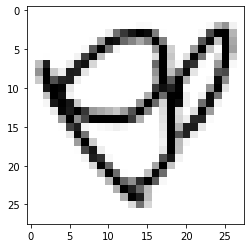

In [5]:
plt.imshow(data[42,:,:,0], cmap="Greys")

## Discriminator Network

In [17]:
def build_discriminator(depth=64, p=0.4):
    # Input layer
    image = Input((img_w, img_h,1))
    
    # Convolutional layers
    conv1 = Conv2D(depth*1, 5, strides=2, padding='same', activation=tensorflow.keras.layers.LeakyReLU(alpha=0.01))(image)
    conv1 = Dropout(p)(conv1)
    conv2 = Conv2D(depth*2, 5, strides=2, padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    conv3 = Conv2D(depth*4, 5, strides=2, padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    conv4 = Conv2D(depth*8, 5, strides=1, padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))
    
    # Output layer
    pred = Dense(1, activation='sigmoid')(conv4)
    
    # Model definition
    model = Model(inputs=image, outputs=pred)
    
    return model



In [18]:
discriminator = build_discriminator()
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 4, 256)         0   

In [11]:
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=Nadam(lr=0.0008, clipvalue=1.0), 
                      metrics=['accuracy'])

NameError: name 'discriminator' is not defined

## Generator Network

In [12]:
z_dimensions = 32

In [13]:
def build_generator(latent_dim=z_dimensions, depth=64, p=0.4):
    
    # Define inputs
    noise = Input((latent_dim,))
    
    # First dense layer
    dense1 = Dense(7*7*depth)(noise)
    dense1 = BatchNormalization(momentum=0.9)(dense1) # default momentum for moving average is 0.99
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,depth))(dense1)
    dense1 = Dropout(p)(dense1)
    
    # De-Convolutional layers
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    conv3 = Conv2DTranspose(int(depth/8), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    # Output layer
    image = Conv2D(1, kernel_size=5, padding='same', 
                   activation='sigmoid')(conv3)

    # Model definition    
    model = Model(inputs=noise, outputs=image)
    
    return model

In [14]:
generator = build_generator()
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_1 (Dense)             (None, 3136)              103488    
                                                                 
 batch_normalization (BatchN  (None, 3136)             12544     
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 3136)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 64)          0         
                                                           

## Adversarial Network

In [15]:
z = Input(shape=(z_dimensions,))
img = generator(z)
discriminator.trainable = False
pred = discriminator(img)
adversarial_model = Model(z, pred)

In [16]:
adversarial_model.compile(loss='binary_crossentropy', 
                          optimizer=Nadam(lr=0.0004, clipvalue=1.0), 
                          metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


### Time to train!

In [17]:
def train(epochs=2000, batch=128, z_dim=z_dimensions):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(1,epochs+1): 
        # sample real images: 
        real_imgs = np.reshape(data[np.random.choice(data.shape[0],batch,replace=False)],(batch,28,28,1))
        
        # generate fake images: 
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, z_dim]))
        
        # concatenate images as discriminator inputs:
        X = np.concatenate((real_imgs,fake_imgs))
        
        # assign y labels for discriminator: 
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        
        # train discriminator: 
        d_metrics.append(discriminator.train_on_batch(X,y))
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        # adversarial net's noise input and "real" y: 
        noise = np.random.uniform(-1.0,1.0,size=[batch, z_dim])
        y = np.ones([batch,1])
        
        # train adversarial net: 
        a_metrics.append(adversarial_model.train_on_batch(noise,y)) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        # periodically print progress & fake images: 
        if i%100 == 0:
            print('Epoch #{}'.format(i))
            log_mesg = "%d: [Discriminator loss: %f, acc: %f]" % \
            (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [Generator loss: %f, acc: %f]" % \
            (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, size=[16, z_dim])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], cmap='Greys')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics

Epoch #20
20: [Discriminator loss: 0.252834, acc: 0.877930]  [Generator loss: 2.589701, acc: 0.092188]


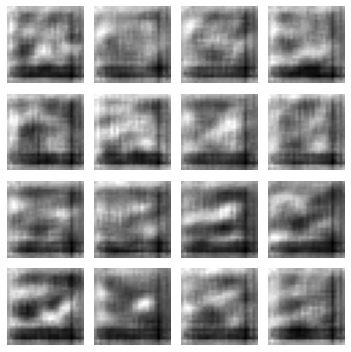

Epoch #40
40: [Discriminator loss: 0.233601, acc: 0.925781]  [Generator loss: 2.494229, acc: 0.204297]


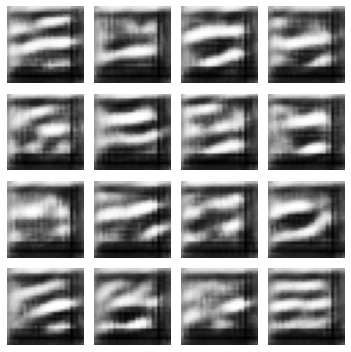

Epoch #60
60: [Discriminator loss: 0.158640, acc: 0.950065]  [Generator loss: 2.907202, acc: 0.186458]


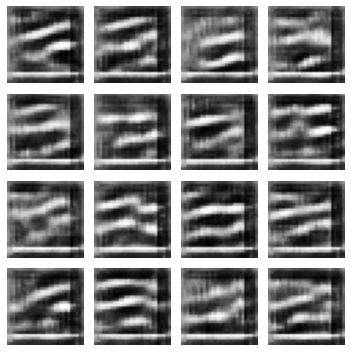

Epoch #80
80: [Discriminator loss: 0.174933, acc: 0.955664]  [Generator loss: 2.573164, acc: 0.295312]


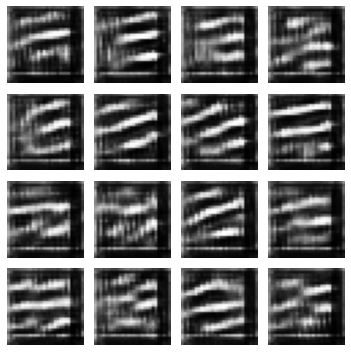

Epoch #100
100: [Discriminator loss: 0.176092, acc: 0.957031]  [Generator loss: 2.529831, acc: 0.248594]


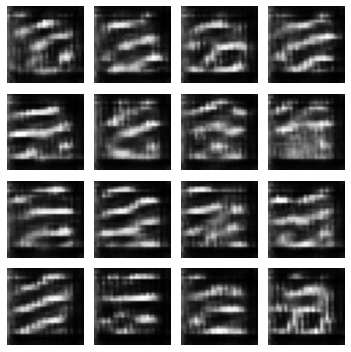

Epoch #120
120: [Discriminator loss: 0.196798, acc: 0.952865]  [Generator loss: 2.482464, acc: 0.225781]


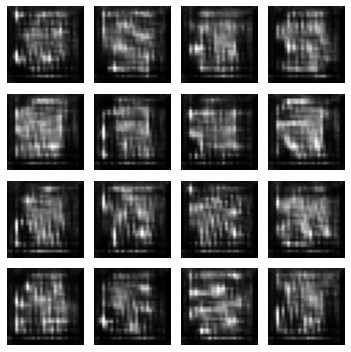

Epoch #140
140: [Discriminator loss: 0.205156, acc: 0.946205]  [Generator loss: 2.502945, acc: 0.209933]


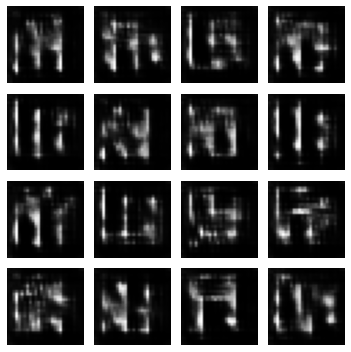

Epoch #160
160: [Discriminator loss: 0.199009, acc: 0.946484]  [Generator loss: 2.621588, acc: 0.187891]


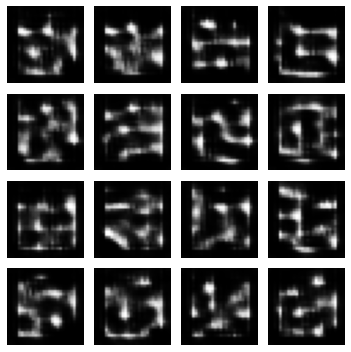

Epoch #180
180: [Discriminator loss: 0.188504, acc: 0.948307]  [Generator loss: 2.813519, acc: 0.167795]


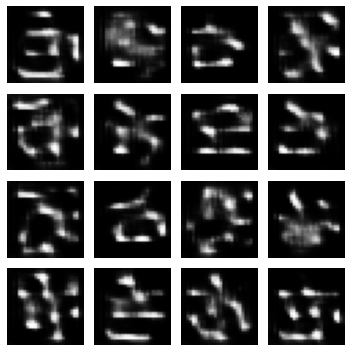

Epoch #200
200: [Discriminator loss: 0.199651, acc: 0.942383]  [Generator loss: 2.846780, acc: 0.160273]


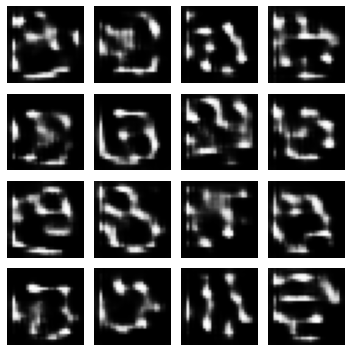

Epoch #220
220: [Discriminator loss: 0.199094, acc: 0.941619]  [Generator loss: 2.916392, acc: 0.150852]


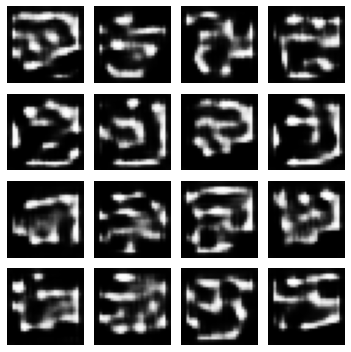

Epoch #240
240: [Discriminator loss: 0.198356, acc: 0.940218]  [Generator loss: 2.930318, acc: 0.142546]


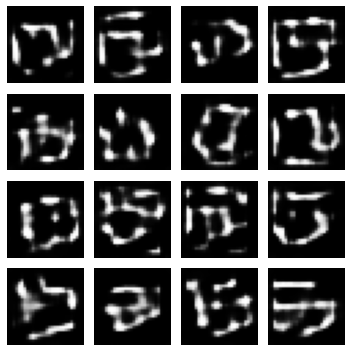

Epoch #260
260: [Discriminator loss: 0.201322, acc: 0.936989]  [Generator loss: 2.948345, acc: 0.137740]


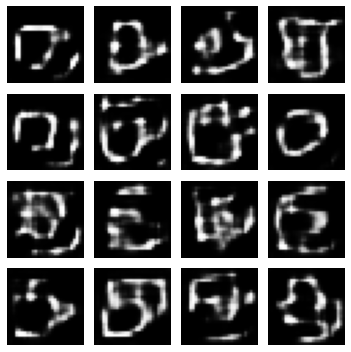

Epoch #280
280: [Discriminator loss: 0.201108, acc: 0.935658]  [Generator loss: 2.956813, acc: 0.133622]


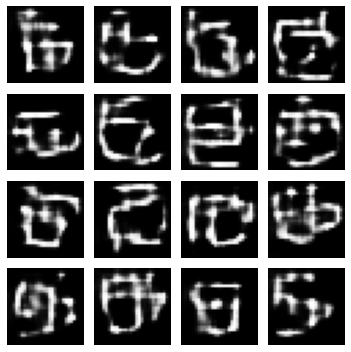

Epoch #300
300: [Discriminator loss: 0.208320, acc: 0.931055]  [Generator loss: 2.950169, acc: 0.130078]


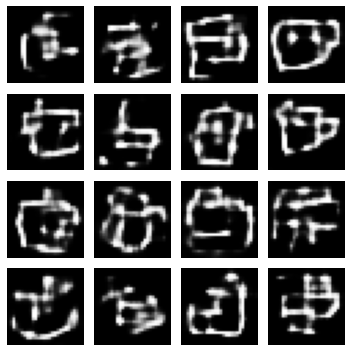

Epoch #320
320: [Discriminator loss: 0.216552, acc: 0.925977]  [Generator loss: 2.918425, acc: 0.129102]


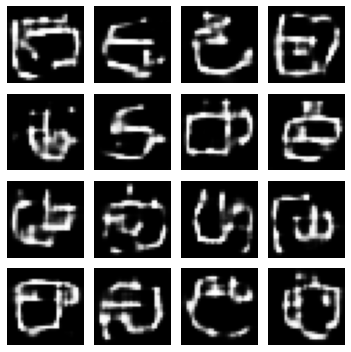

Epoch #340
340: [Discriminator loss: 0.222723, acc: 0.921852]  [Generator loss: 2.888945, acc: 0.127803]


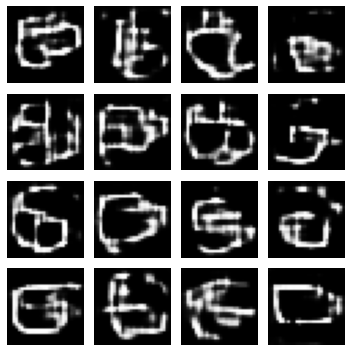

Epoch #360
360: [Discriminator loss: 0.228998, acc: 0.918218]  [Generator loss: 2.862211, acc: 0.126519]


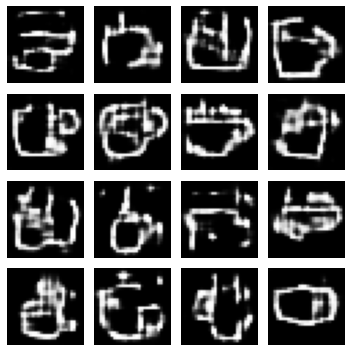

Epoch #380
380: [Discriminator loss: 0.236034, acc: 0.914289]  [Generator loss: 2.833429, acc: 0.125761]


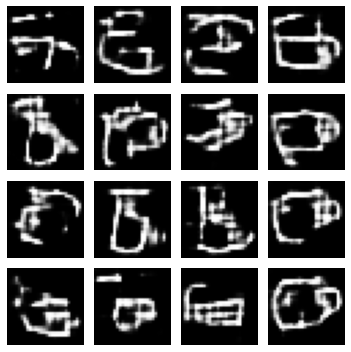

Epoch #400
400: [Discriminator loss: 0.243366, acc: 0.910205]  [Generator loss: 2.806278, acc: 0.125527]


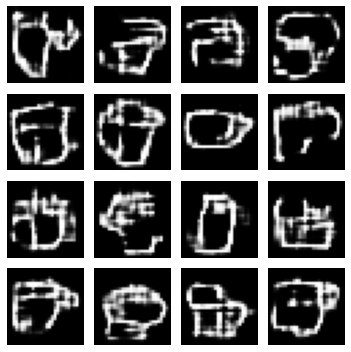

Epoch #420
420: [Discriminator loss: 0.249034, acc: 0.906901]  [Generator loss: 2.783577, acc: 0.124981]


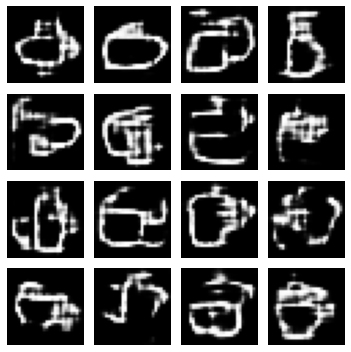

Epoch #440
440: [Discriminator loss: 0.254126, acc: 0.903960]  [Generator loss: 2.756696, acc: 0.124840]


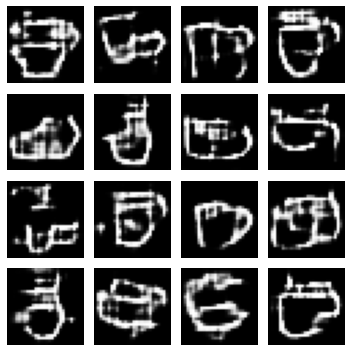

Epoch #460
460: [Discriminator loss: 0.259364, acc: 0.900951]  [Generator loss: 2.732423, acc: 0.124932]


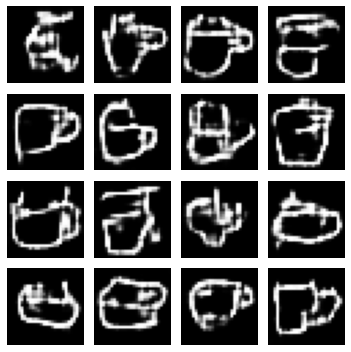

Epoch #480
480: [Discriminator loss: 0.264147, acc: 0.898014]  [Generator loss: 2.712412, acc: 0.125081]


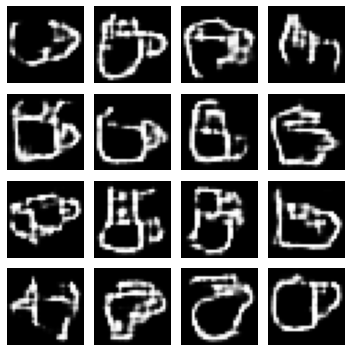

Epoch #500
500: [Discriminator loss: 0.268561, acc: 0.895594]  [Generator loss: 2.689760, acc: 0.125438]


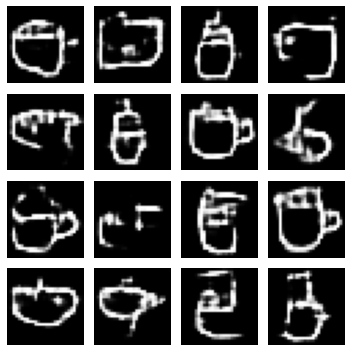

Epoch #520
520: [Discriminator loss: 0.272430, acc: 0.893134]  [Generator loss: 2.668461, acc: 0.126127]


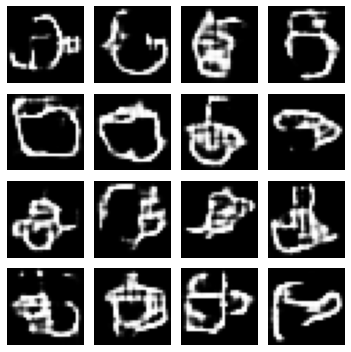

Epoch #540
540: [Discriminator loss: 0.275908, acc: 0.891124]  [Generator loss: 2.650465, acc: 0.126085]


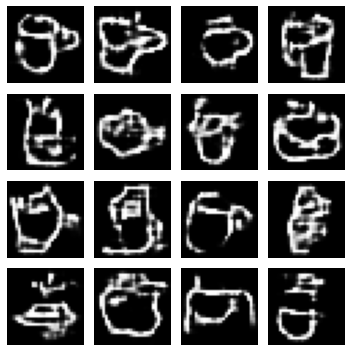

Epoch #560
560: [Discriminator loss: 0.279797, acc: 0.888735]  [Generator loss: 2.628202, acc: 0.126018]


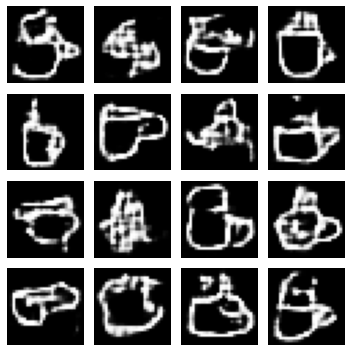

Epoch #580
580: [Discriminator loss: 0.282954, acc: 0.886853]  [Generator loss: 2.610712, acc: 0.125606]


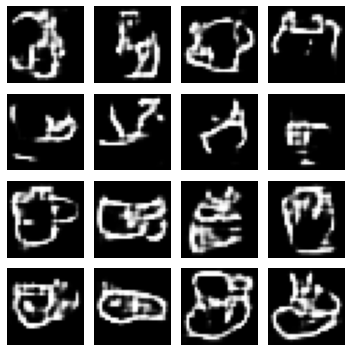

Epoch #600
600: [Discriminator loss: 0.285610, acc: 0.885371]  [Generator loss: 2.593663, acc: 0.125260]


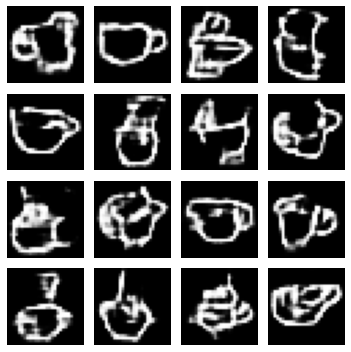

Epoch #620
620: [Discriminator loss: 0.288463, acc: 0.883783]  [Generator loss: 2.580870, acc: 0.125000]


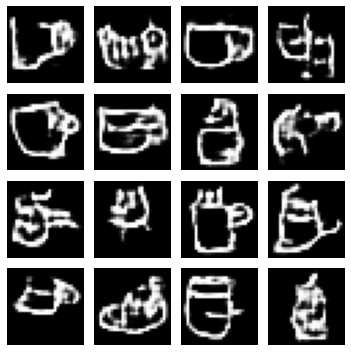

Epoch #640
640: [Discriminator loss: 0.290748, acc: 0.882544]  [Generator loss: 2.567415, acc: 0.124475]


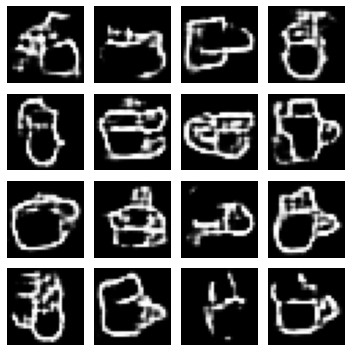

Epoch #660
660: [Discriminator loss: 0.292833, acc: 0.881321]  [Generator loss: 2.557110, acc: 0.123651]


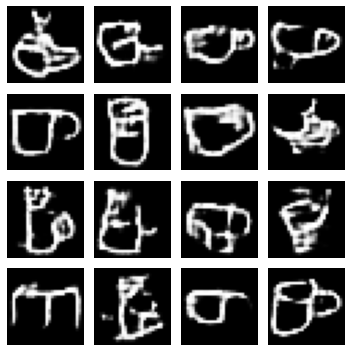

Epoch #680
680: [Discriminator loss: 0.294840, acc: 0.880308]  [Generator loss: 2.547641, acc: 0.123162]


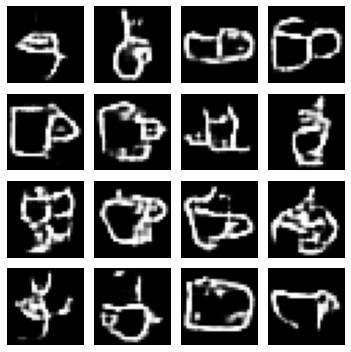

Epoch #700
700: [Discriminator loss: 0.296787, acc: 0.879157]  [Generator loss: 2.536087, acc: 0.122924]


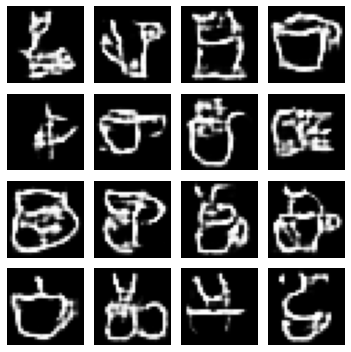

Epoch #720
720: [Discriminator loss: 0.298117, acc: 0.878337]  [Generator loss: 2.525529, acc: 0.122331]


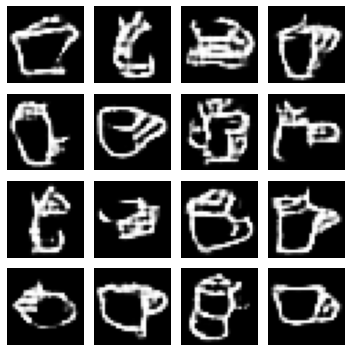

Epoch #740
740: [Discriminator loss: 0.299492, acc: 0.877433]  [Generator loss: 2.520443, acc: 0.121801]


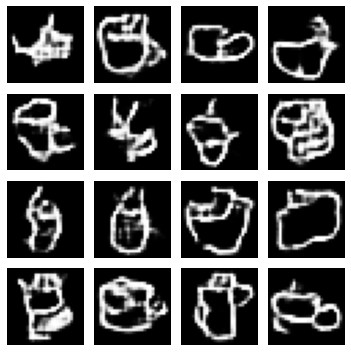

Epoch #760
760: [Discriminator loss: 0.299611, acc: 0.877344]  [Generator loss: 2.517166, acc: 0.121032]


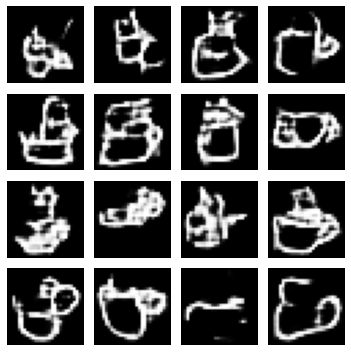

Epoch #780
780: [Discriminator loss: 0.301052, acc: 0.876412]  [Generator loss: 2.511718, acc: 0.120583]


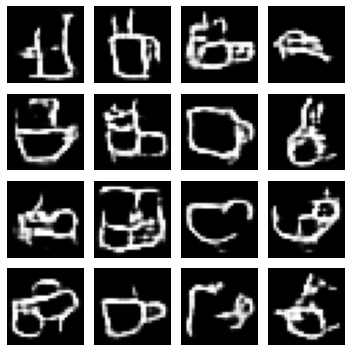

Epoch #800
800: [Discriminator loss: 0.302022, acc: 0.875820]  [Generator loss: 2.508393, acc: 0.120195]


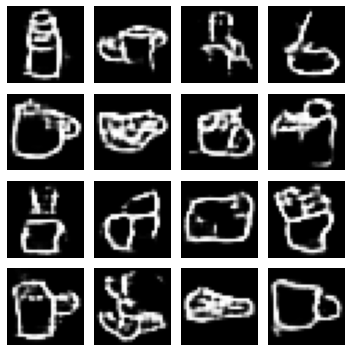

Epoch #820
820: [Discriminator loss: 0.302986, acc: 0.875295]  [Generator loss: 2.503127, acc: 0.119607]


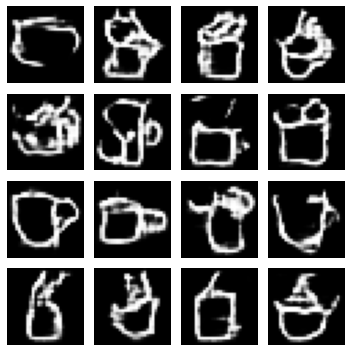

Epoch #840
840: [Discriminator loss: 0.303956, acc: 0.874758]  [Generator loss: 2.498885, acc: 0.119010]


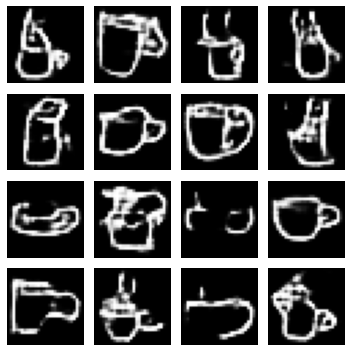

Epoch #860
860: [Discriminator loss: 0.304842, acc: 0.874155]  [Generator loss: 2.496390, acc: 0.118550]


In [ ]:
a_metrics_complete, d_metrics_complete = train()

In [ ]:
ax = pd.DataFrame(
    {'Generator': [metric[0] for metric in a_metrics_complete],
     'Discriminator': [metric[0] for metric in d_metrics_complete],}).plot(title='Training Loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

In [ ]:
ax = pd.DataFrame(
    {'Generator': [metric[1] for metric in a_metrics_complete],
     'Discriminator': [metric[1] for metric in d_metrics_complete],}).plot(title='Training Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")